# L4 Fields Analysis : allnadirs vs allnadirs+swot
- plot SSH, KE, normalized vorticity... 

In [1]:
import os
import sys

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import xarray as xr

import jax
import jax.numpy as jnp
import jaxparrow as jpw

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *


%matplotlib inline
from matplotlib import pyplot as plt

path_save_plot = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-06-20_L4Fields_comparison'

bbox_drifters = [0, 13.5, 36.5, 44]
bbox_mediterranea = [-5.8, 36.5, 30, 44.5]

#### func

In [2]:
def plot2d(lon, lat, data, bbox: tuple=bbox_mediterranea, cmap='Oranges', center_bar=False, vmax=None, vmin=None, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points

    # vmin, vmax
    if not vmax:
            vmax = np.nanmax(np.abs(data))
    if not vmin:                
        if center_bar:
            vmin = - vmax
        else:
            vmin = np.nanmin(data)


    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')

    
    ax.set_title(title)
        
    ### SAVE
    if save_name:
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [3]:
# MIOST field data

path = '/home/bouxdecl/Documents/my_python/MIOST/data_RESULTS/'
ds_nadir = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_GOOD.nc'))
ds_swot = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_and_SWOT_GOOD.nc'))

# add t-grid values for velocities

ds_nadir = add_Tgrid_velocities(ds_nadir)
ds_swot  = add_Tgrid_velocities(ds_swot)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
# reduce time span
start_time = '2020-05-01'
end_time = '2024-05-31'

#choose between bbox_mediterranea & bbox_drifters
bbox = bbox_drifters


# dataset span
print(ds_nadir.time.min().values)
print(ds_nadir.time.max().values)

2023-03-28T00:00:00.000000000
2023-07-10T00:00:00.000000000


#### SSH


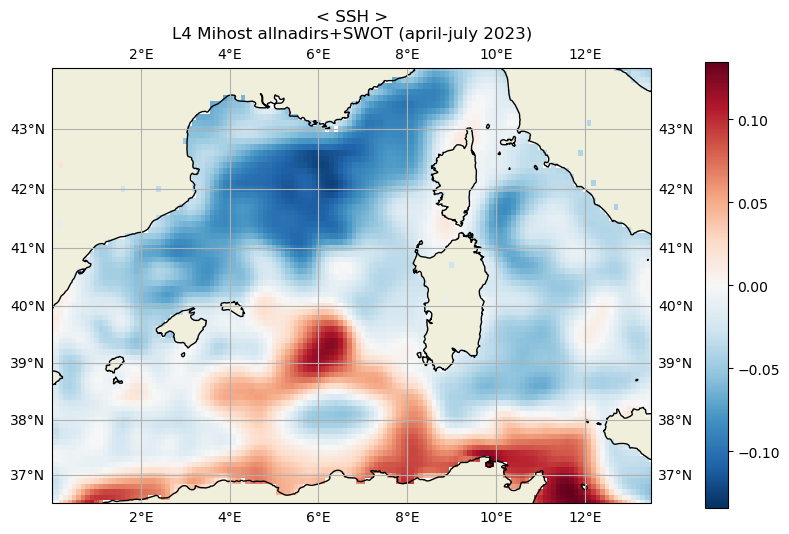

In [9]:
bbox = bbox_drifters

# NADIR
ds = ds_swot

#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude


plot2d(lon, lat, ds.ssh.mean(dim='time'), bbox, cmap='RdBu_r', center_bar=True, title='< SSH >\nL4 Mihost allnadirs+SWOT (april-july 2023)', save_name='SSH_mean_L4.png')


#### KE moyen

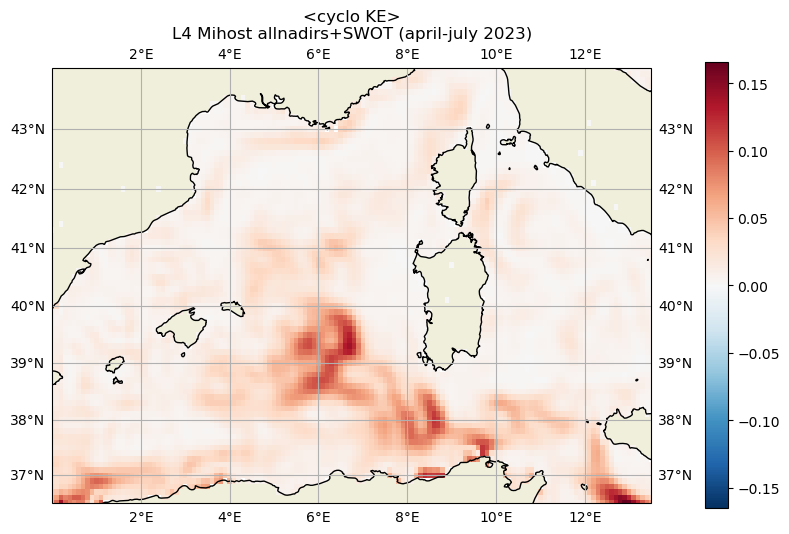

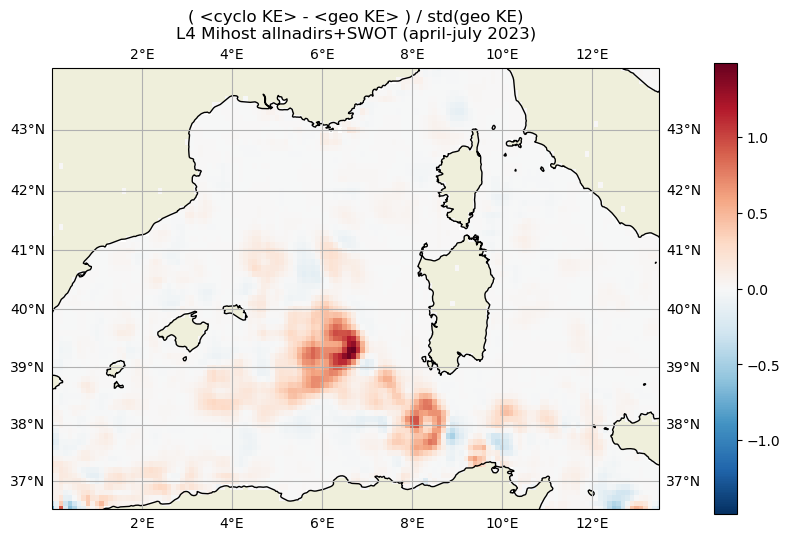

In [22]:

# NADIR
ds = ds_swot

#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var = ( ds.u_var_t**2 + ds.v_var_t**2   ).mean(dim='time') 
KE_geo = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).mean(dim='time') 

#plot data
plot2d(lon, lat, KE_var, bbox, cmap='RdBu_r', center_bar=True, title='<cyclo KE>\nL4 Mihost allnadirs+SWOT (april-july 2023)', save_name='KE_cyclo_mean_L4')
#plot2d(lon, lat, KE_geo, bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')
#plot2d(lon, lat, (KE_var - KE_geo)/KE_geo, bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')

plot2d(lon, lat, (KE_var - KE_geo)/np.nanstd(KE_geo), bbox, cmap='RdBu_r', center_bar=True, title='( <cyclo KE> - <geo KE> ) / std(geo KE)\nL4 Mihost allnadirs+SWOT (april-july 2023)',
       save_name='KE_diffcyclo_geo_mean_L4')


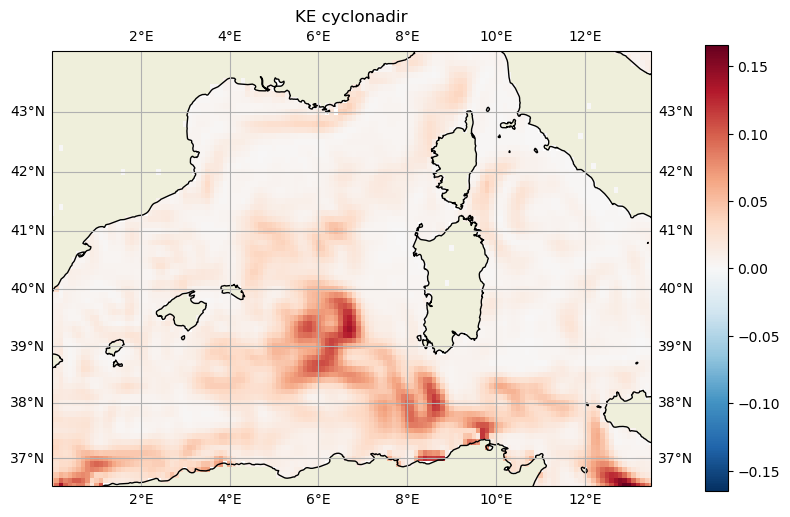

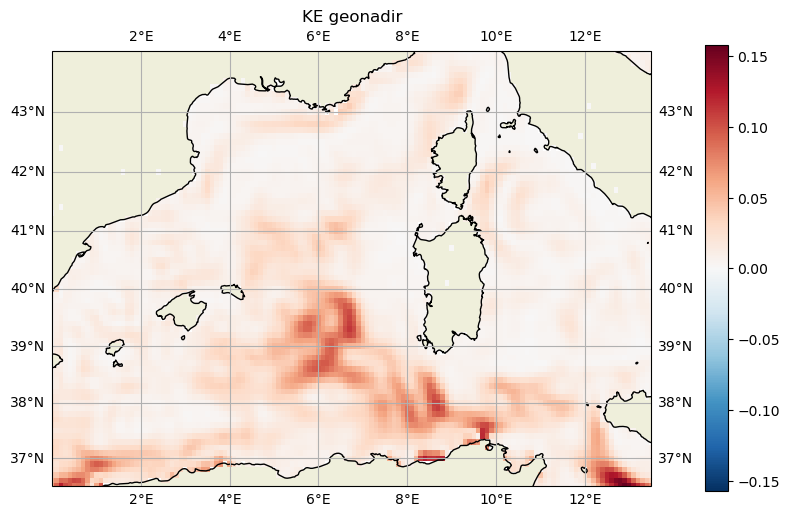

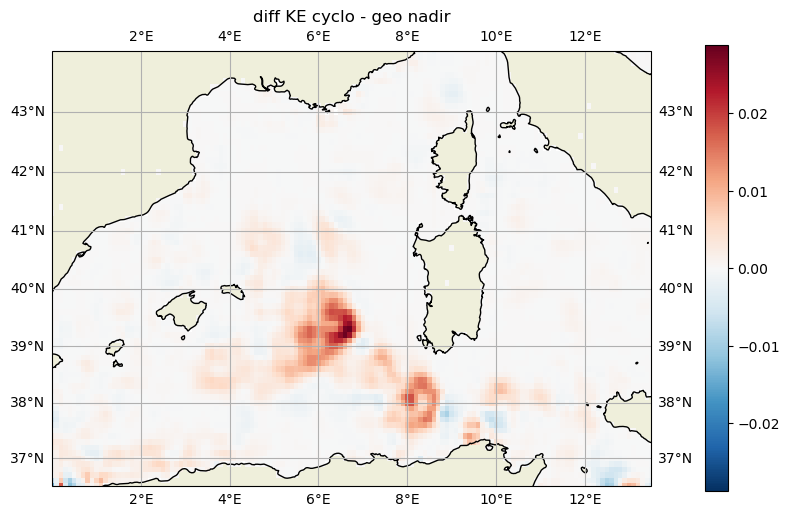

In [11]:

# SWOT
ds = ds_swot 


#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var = ( ds.u_var_t**2 + ds.v_var_t**2   ).mean(dim='time') 
KE_geo = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).mean(dim='time') 

#plot data
plot2d(lon, lat, KE_var, bbox, cmap='RdBu_r', center_bar=True, title='KE cyclonadir', save_name='')
plot2d(lon, lat, KE_geo, bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')
plot2d(lon, lat, (KE_var - KE_geo), bbox, cmap='RdBu_r', center_bar=True, title='diff KE cyclo - geo nadir')

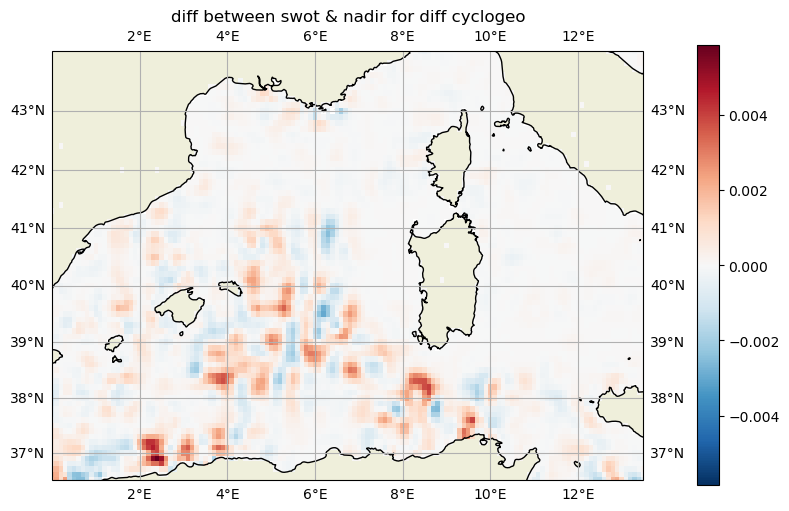

In [12]:
ds = ds_nadir
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))
KE_var_nadir = ( ds.u_var_t**2 + ds.v_var_t**2   ).mean(dim='time') 
KE_geo_nadir = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).mean(dim='time') 

ds = ds_swot
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))
KE_var_swot = ( ds.u_var_t**2 + ds.v_var_t**2   ).mean(dim='time') 
KE_geo_swot = ( ds.u_geos_t**2 + ds.v_geos_t**2 ).mean(dim='time') 

compa = (KE_var_swot - KE_geo_swot) - (KE_var_nadir - KE_geo_nadir)   

plot2d(lon, lat, compa, bbox, cmap='RdBu_r', center_bar=True, title='diff between swot & nadir for diff cyclogeo')

#### KE courant moyens

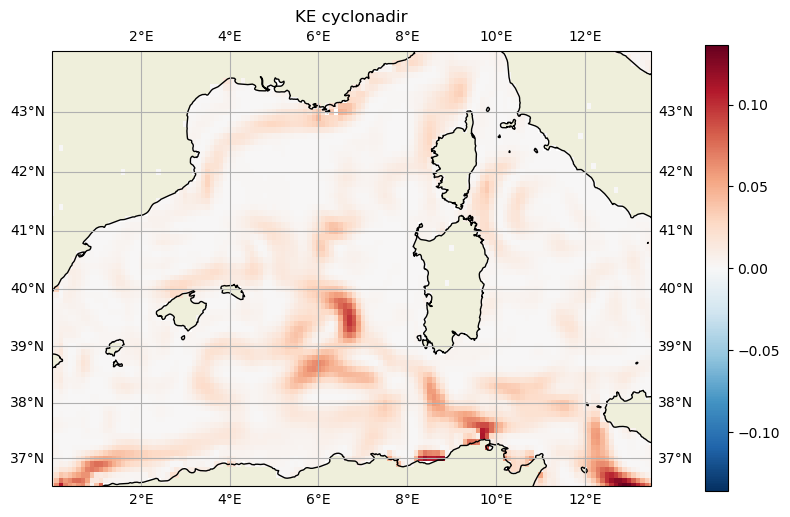

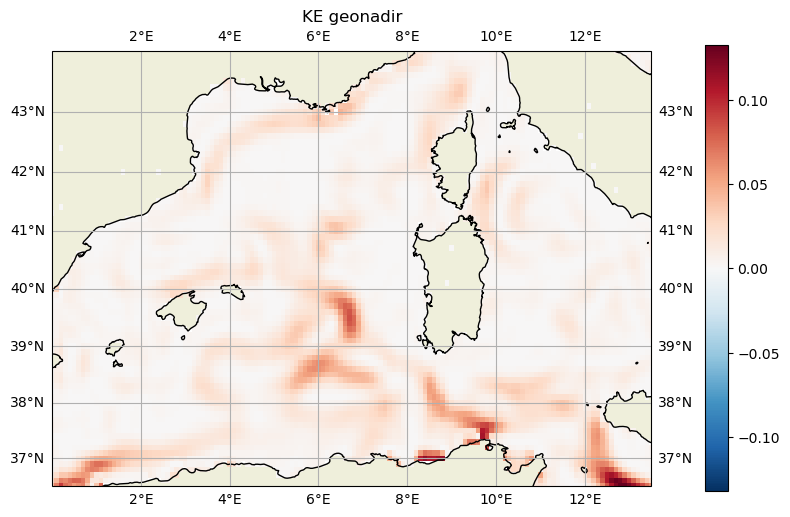

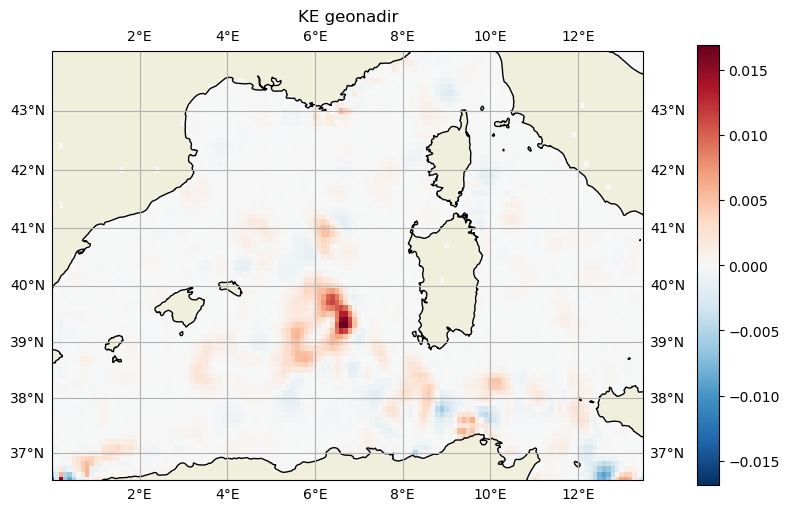

In [13]:
# NADIR

ds = ds_nadir


#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var = (ds.u_var_t.mean(dim='time')**2 + ds.v_var_t.mean(dim='time')**2) 
KE_geo = (ds.u_geos_t.mean(dim='time')**2 + ds.v_geos_t.mean(dim='time')**2) 

#plot data
plot2d(lon, lat, KE_var, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE cyclonadir')
plot2d(lon, lat, KE_geo, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')
plot2d(lon, lat, (KE_var - KE_geo), bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')

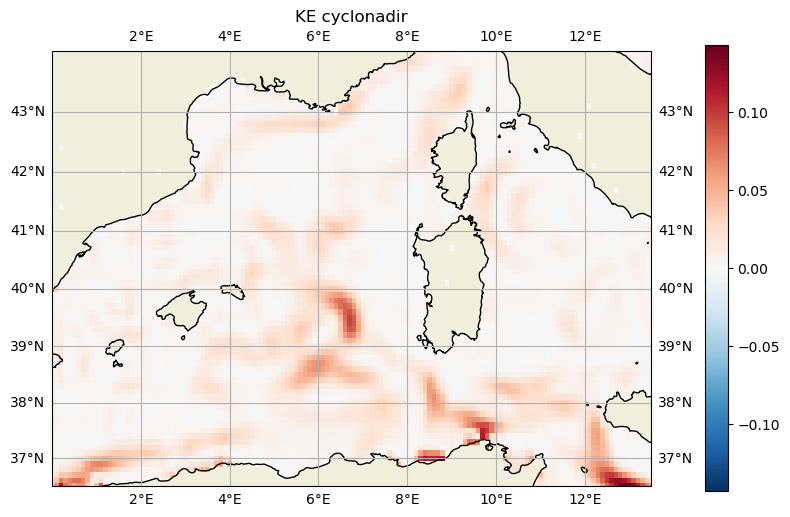

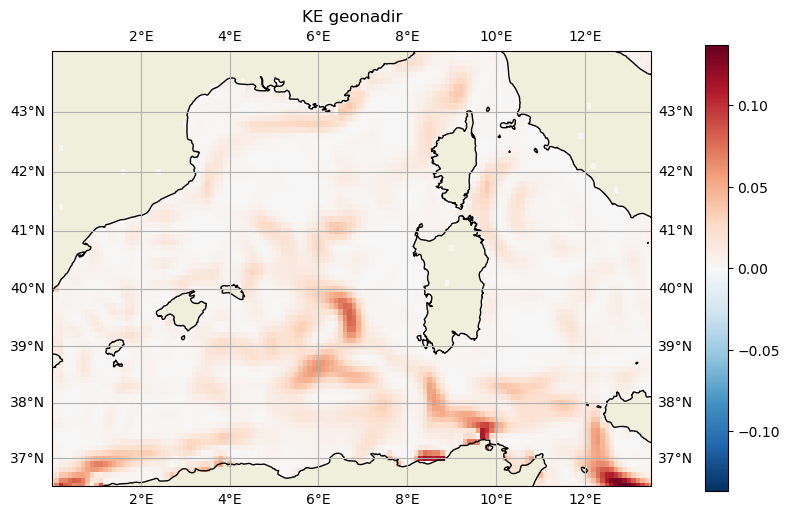

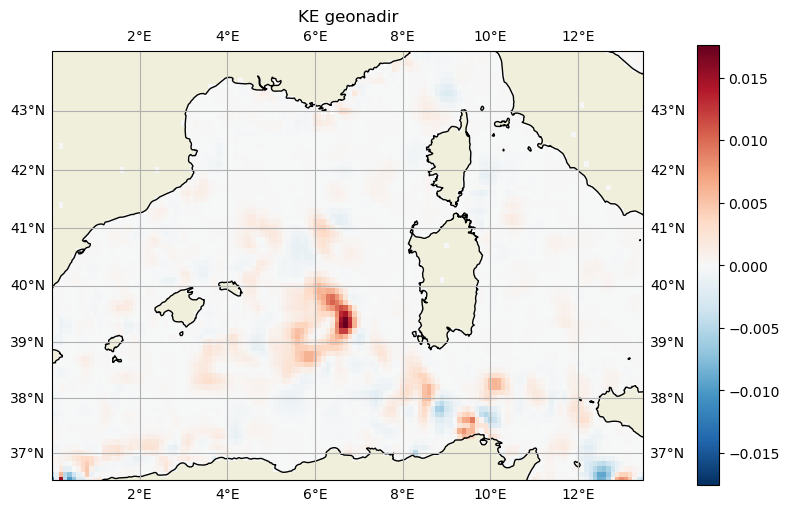

In [14]:
# SWOT

ds = ds_swot


#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var = (ds.u_var_t.mean(dim='time')**2 + ds.v_var_t.mean(dim='time')**2) 
KE_geo = (ds.u_geos_t.mean(dim='time')**2 + ds.v_geos_t.mean(dim='time')**2) 

#plot data
plot2d(lon, lat, KE_var, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE cyclonadir')
plot2d(lon, lat, KE_geo, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')
plot2d(lon, lat, (KE_var - KE_geo), bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')

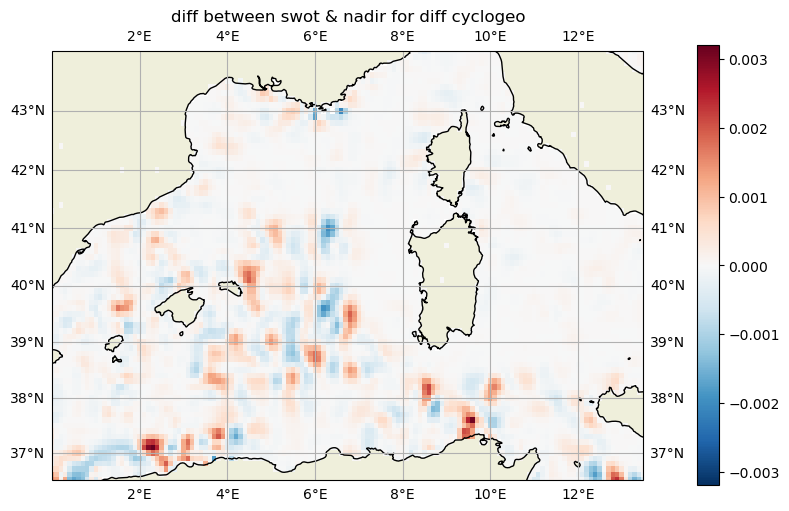

In [15]:
ds = ds_nadir
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))
KE_var_nadir = ( ds.u_var_t.mean(dim='time') **2 + ds.v_var_t.mean(dim='time') **2   )
KE_geo_nadir = ( ds.u_geos_t.mean(dim='time') **2 + ds.v_geos_t.mean(dim='time') **2 )

ds = ds_swot
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))
KE_var_swot = ( ds.u_var_t.mean(dim='time') **2 + ds.v_var_t.mean(dim='time') **2   )
KE_geo_swot = ( ds.u_geos_t.mean(dim='time') **2 + ds.v_geos_t.mean(dim='time') **2 )

compa = (KE_var_swot - KE_geo_swot) - (KE_var_nadir - KE_geo_nadir)   

plot2d(lon, lat, compa, bbox, cmap='RdBu_r', center_bar=True, title='diff between swot & nadir for diff cyclogeo')

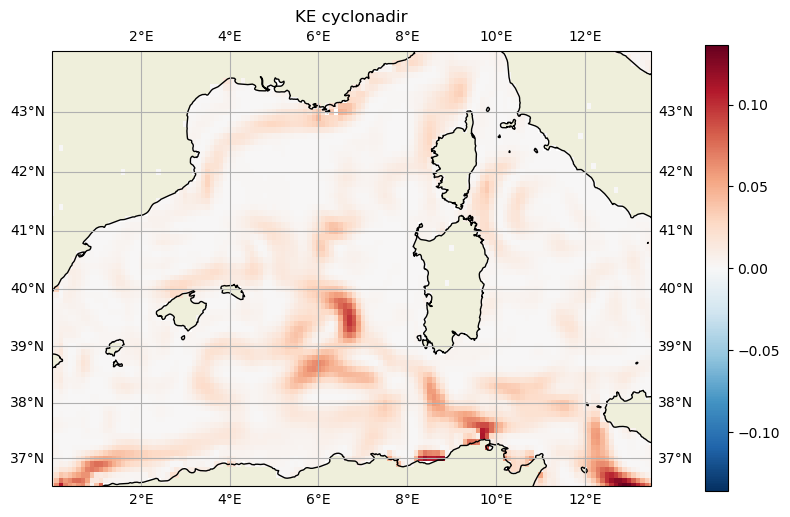

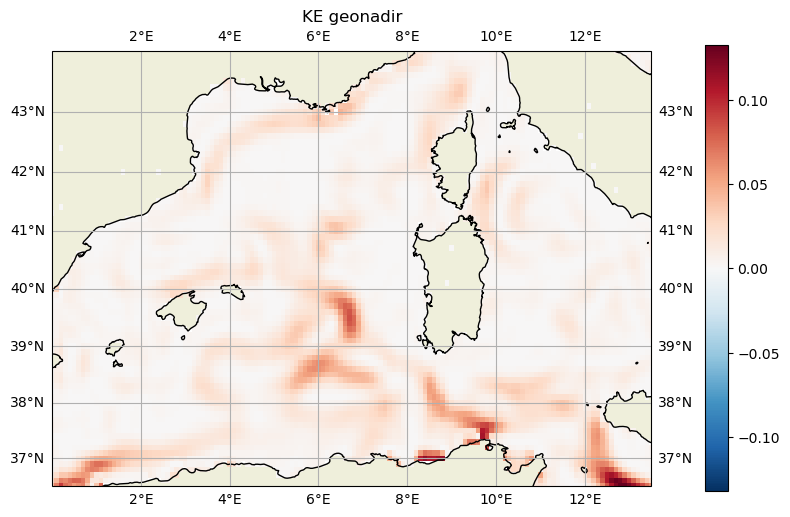

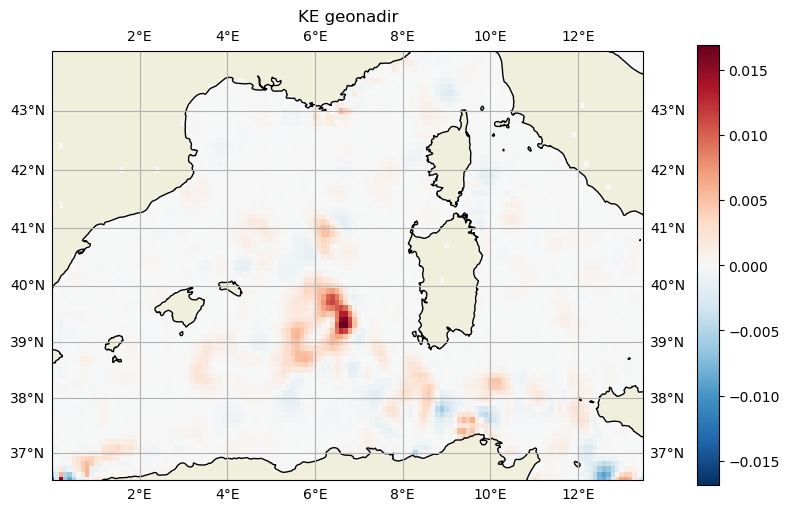

In [16]:
# NADIR

ds = ds_nadir


#select data
ds = restrain_domain(ds, *bbox)
ds = ds.sel(time=slice(start_time, end_time))

#get data
lon, lat = ds.longitude, ds.latitude

KE_var = (ds.u_var_t.mean(dim='time')**2 + ds.v_var_t.mean(dim='time')**2) 
KE_geo = (ds.u_geos_t.mean(dim='time')**2 + ds.v_geos_t.mean(dim='time')**2) 

#plot data
plot2d(lon, lat, KE_var, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE cyclonadir')
plot2d(lon, lat, KE_geo, bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')
plot2d(lon, lat, (KE_var - KE_geo), bbox=bbox, cmap='RdBu_r', center_bar=True, title='KE geonadir')

### Vorticity mean

In [19]:
ds=ds_swot
#ds = ds.interp(time='2023-05-15')
ds = ds.sel(time=slice(start_time, end_time)).mean(dim='time')

u_geos = jnp.copy(ds.u_geos.values)
v_geos = jnp.copy(ds.v_geos.values)
u_var = jnp.copy(ds.u_var.values)
v_var = jnp.copy(ds.v_var.values)

lon_t = jnp.copy(ds.longitude.values)
lat_t = jnp.copy(ds.latitude.values)

'''
lat_u = lat
lat_v = lat
lon_u = lon
lon_v = lon
'''

mask = jnp.isnan(u_geos)

lat_u, lon_u, lat_v, lon_v = jpw.tools.geometry.compute_uv_grids(lat_t, lon_t)

norm_vorticity_geos_raw = jpw.tools.kinematics.normalized_relative_vorticity(u_geos, v_geos, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)
norm_vorticity_var_raw  = jpw.tools.kinematics.normalized_relative_vorticity(u_var, v_var, lat_u, lon_u, lat_v, lon_v, mask, interpolate=True)

In [20]:
norm_vorticity_geos_raw = np.array(norm_vorticity_geos_raw)
norm_vorticity_geos = norm_vorticity_geos_raw[norm_vorticity_geos_raw>3] = 3
norm_vorticity_var, _  = replace_outliers_with_nan_zscore(np.array(norm_vorticity_var_raw), 3)

diff = (norm_vorticity_var - norm_vorticity_geos)
diff, _  = replace_outliers_with_nan_zscore(np.array(diff), 3)

(141, 417)

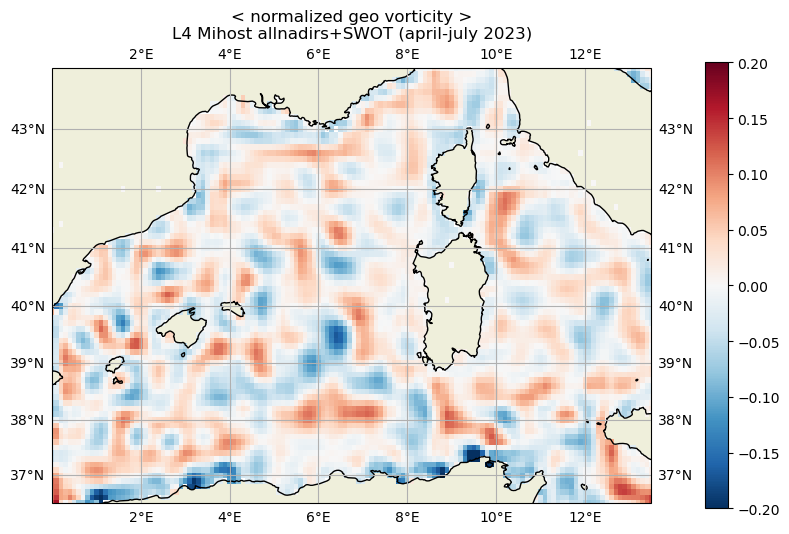

In [23]:
#plot data

plot2d(lon_t, lat_t, norm_vorticity_geos_raw, bbox, vmax=0.2, cmap='RdBu_r', center_bar=True, title='< normalized geo vorticity >\nL4 Mihost allnadirs+SWOT (april-july 2023)', save_name='Vorti_mean_L4.png')